<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])
Epoch: 1/15.. Training loss: 0.914.. Test loss: 0.557.. Test Accuracy: 0.795
Epoch: 2/15.. Training loss: 0.558.. Test loss: 0.481.. Test Accuracy: 0.823
Epoch: 3/15.. Training loss: 0.490.. Test loss: 0.451.. Test Accuracy: 0.835
Epoch: 4/15.. Training loss: 0.452.. Test loss: 0.424.. Test Accuracy: 0.846
Epoch: 5/15.. Training loss: 0.425.. Test loss: 0.411.. Test Accuracy: 0.850
Epoch: 6/15.. Training loss: 0.401.. Test loss: 0.393.. Test Accuracy: 0.855
Epoch: 7/15.. Training loss: 0.385.. Test loss: 0.383.. Test Accuracy: 0.860
Epoch: 8/15.. Training loss: 0.373.. Test loss: 0.374.. Test Accuracy: 0.865
Epoch: 9/15.. Training loss: 0.359.. Test loss: 0.373.. Test Accuracy: 0.866
Epoch: 10/15.. Training loss: 0.349.. Test loss: 0.356.. Test Accuracy: 0.873
Epoch: 11/15.. Training loss: 0.337.. Test loss: 0.360.. Test Accuracy: 0.871
Epoch: 12/15.. Training loss: 0.331.. Test loss: 0.349.. Test Accuracy: 0.876
Epoch

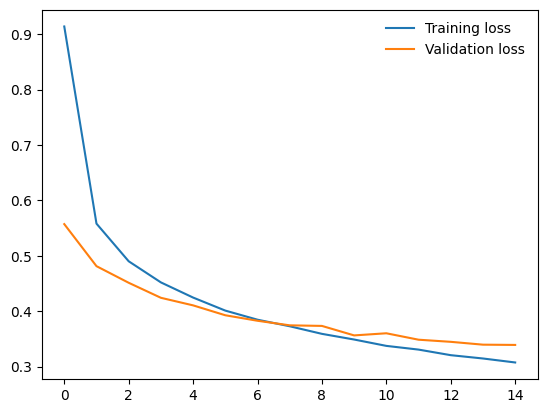

In [43]:
# Import the necessary libraries
#%%
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)
     
# Examine a sample
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
     
model = nn.Sequential(nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
            # nn.Softmax(dim=1)
           )

# Define the loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

# Define the epochs
epochs = 15

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
#%%    
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [44]:
torch.save(model.state_dict(), 'model.pth')

In [45]:
model = nn.Sequential(nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
            # nn.Softmax(dim=1)
           )
model.load_state_dict(torch.load('model.pth'))
model.eval() 

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)

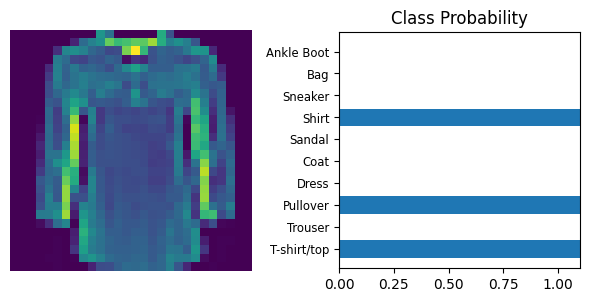

In [46]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()  


# Testing out the network
dataiter = iter(trainloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.resize_(1, 784)

with torch.no_grad():
    # Calculate the class probabilities (softmax) for img
    logps = model(img)
    ps = (logps)
# Calculate the class probabilites (log softmax) for img
ps = (model(img))

# Plot the image and probabilites
view_classify(img, ps, version='Fashion')

In [ ]:
import hls4ml
config = hls4ml.utils.config_from_pytorch_model(
     model,
     input_shape=(1, 784),
     granularity='name',
     default_precision='fixed<16,6>',
     backend='Catapult')

hls_model = hls4ml.converters.convert_from_pytorch_model(
     model,
     hls_config=config,
     output_dir="output",
     backend='VivadoAccelerator',
     io_type='io_stream',
     board='pynq-z2',
  )

hls_model.compile()
# hls_model.build(reset=True)
numpy_img = img.numpy()
hls_prediction = hls_model.predict(numpy_img)
print(type(hls_prediction))




Interpreting Model ...
Topology:
Layer name: _0, layer type: Dense, input shape: [[None, 1, 784]]
Layer name: _1, layer type: Activation, input shape: [[None, 1, 256]]
Layer name: _3, layer type: Dense, input shape: [[None, 1, 256]]
Layer name: _4, layer type: Activation, input shape: [[None, 1, 128]]
Layer name: _6, layer type: Dense, input shape: [[None, 1, 128]]
Layer name: _7, layer type: Activation, input shape: [[None, 1, 64]]
Layer name: _9, layer type: Dense, input shape: [[None, 1, 64]]
Creating HLS model
Writing HLS project
Done


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'output/myproject_test_wrapper.cpp' -> 'output/myproject_test.cpp'

In [ ]:
hls_model.build(bitfile=True)